In [ ]:
import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

import tensorflow as tf

In [ ]:
# The layers and weights of each layer considered when 
# calculating the texture loss during gradient descent.

texture_layers  = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

texture_weights = [
    1.00,
    0.80,
    0.50,
    0.30,
    0.10
]

In [ ]:
# Load the VGG-19 network weights.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

out = [vgg.get_layer(name).output for name in texture_layers]
vgg = tf.keras.Model([vgg.inputs], out)

vgg.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
def get_flattened_layer(tensor):
  ''' Flatten a layer of feature maps in to a 2D tensor / a matrix.

  This function flattens a layer of feature maps in to a 2D tensor / a 
  matrix. If there are N feature maps and each feature map is of 
  dimensions P by Q then the matrix will be of dimensions N by M
  where M = P * Q.

  Parameters:
    tensor (tf.Tensor) - The tensor of feature maps to be flattened.
  
  Returns:
    The feature maps flattened in to a 2D tensor / a matrix.
  '''
  temp = tf.squeeze(tensor)
  temp = tf.transpose(temp, [2, 0, 1])

  h, w = temp.shape[0], temp.shape[1] * temp.shape[2]
  temp = tf.reshape(temp, [h, w])

  return temp

In [ ]:
def get_gram_matrix(tensor):
  ''' Get the gram matrix for a layer of feature maps.

  This function returns the gram matrix for a layer of feature maps. As per the
  paper "Image Style Transfer Using Convolutional Neural Networks" 
  (Gatys et al. 2014) this is the matrix of covariances between
  the feature maps in the layer.

  Parameters:
    tensor (tf.Tensor) - The tensor of feature maps in the layer.
  
  Returns:
    The gram matrix for the layer of feature maps.
  '''

  temp = get_flattened_layer(tensor)
  temp = tf.matmul(temp, temp, transpose_b=True)
  
  gram = tf.expand_dims(temp, axis=0)
  return gram

In [ ]:
def get_texture_loss(texture_targets, texture_outputs):
  ''' Return the loss between content targets and content outputs.

  This function returns the loss between the texture targets and the texture
  outputs. As per the paper "Image Style Transfer Using Convolutional Neural
  Networks" (Gatys et al. 2014) this loss is the total euclidean between
  the gram matrices of the feature map representations of the images.

  Parameters:
    texture_targets (dict) - The target feature map representations.
    texture_outputs (dict) - The output feature map representations

  Returns:
    The sum of the euclidean distances between the gram matrices of 
    each layer of feature maps in texture_targets/texture_outputs.
  '''

  loss = 0

  for name, weight in zip(texture_layers, texture_weights):
    target_gram = get_gram_matrix(texture_targets[name])
    output_gram = get_gram_matrix(texture_outputs[name])

    N_l, M_l = target_gram.shape[1], target_gram.shape[2]

    loss += weight * tf.math.reduce_sum(
        tf.math.squared_difference(
            target_gram,
            output_gram
        )
    ) / (4 * N_l ** 2 + M_l ** 2)

  return loss

In [ ]:
epochs    = 10_000
optimizer = tf.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)

In [ ]:
def texture_reconstruction(texture, reconstruction, epochs=epochs, optimizer=optimizer):
  ''' Perform texture reconstruction for the given image.

  This function performs texture reconstruction for a given image. As per 
  the paper "Image Style Transfer Using Convolutional Neural Networks"
  (Gatys et al. 2014) this is performed via gradient descent upon the 
  reconstruction image using the difference in gram matrices of the 
  high-level feature maps of the content and reconstruction images 
  for loss.

  Parameters:
    texture         (tf.Variable) - The texture image.
    reconstruction  (tf.Variable) - The reconstruction image.
    
    epochs (int) - The number of epochs for gradient descent.

    optimizer (tf.keras.optimizers.Optimizer) - The gradient descent optimizer.
  '''

  texture_targets = dict(zip(texture_layers, vgg(texture)))

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      
      texture_outputs = dict(zip(texture_layers, vgg(reconstruction)))
      
      loss = get_texture_loss(texture_outputs, texture_targets)
      grad = tape.gradient(loss, reconstruction)

    optimizer.apply_gradients([(grad, reconstruction)])
    reconstruction.assign(tf.clip_by_value(reconstruction, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
      print('Epoch [{:4} / {:4}]: Loss = {:10.4f}'.format(epoch, epochs, loss))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = os.path.join('drive', 'My Drive', 'CITS4404 Project')

texture_path = 'Texture'
texture_file = 'Composition-VII.jpg'

image_h = 512
image_w = 512

In [ ]:
# Read, reshape and scale the texture image.
texture = plt.imread(os.path.join(root, texture_path, texture_file))
texture = texture.reshape([1, image_h, image_w, 3])
texture = texture / 255.0

# Initialize the reconstructed image to white-noise.
initial        = tf.random.uniform([1, image_h, image_w, 3], minval=0.0, maxval=1.0, dtype=tf.float32)
reconstruction = tf.Variable(initial, trainable=True, dtype=tf.float32)

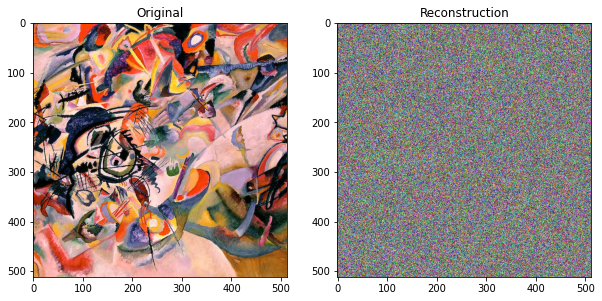

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(texture[0])
ax[1].imshow(reconstruction[0].numpy())

ax[0].set_title('Original')
ax[1].set_title('Reconstruction')

plt.show()

In [ ]:
time_1 = time.time()

texture_reconstruction(texture, reconstruction)

time_2 = time.time()
print('Total elapsed time: {} seconds'.format(time_2 - time_1))

Epoch [   0 / 10000]: Loss = 60865585152.0000
Epoch [ 100 / 10000]: Loss = 694149632.0000
Epoch [ 200 / 10000]: Loss = 161898848.0000
Epoch [ 300 / 10000]: Loss = 60176228.0000
Epoch [ 400 / 10000]: Loss = 28397114.0000
Epoch [ 500 / 10000]: Loss = 15688509.0000
Epoch [ 600 / 10000]: Loss = 10943452.0000
Epoch [ 700 / 10000]: Loss = 8414268.0000
Epoch [ 800 / 10000]: Loss = 6969342.0000
Epoch [ 900 / 10000]: Loss = 6045098.0000
Epoch [1000 / 10000]: Loss = 5395949.5000
Epoch [1100 / 10000]: Loss = 4906901.5000
Epoch [1200 / 10000]: Loss = 4519379.0000
Epoch [1300 / 10000]: Loss = 4197794.0000
Epoch [1400 / 10000]: Loss = 3921926.7500
Epoch [1500 / 10000]: Loss = 3680554.2500
Epoch [1600 / 10000]: Loss = 3465762.7500
Epoch [1700 / 10000]: Loss = 3272157.0000
Epoch [1800 / 10000]: Loss = 3095652.5000
Epoch [1900 / 10000]: Loss = 2933097.5000
Epoch [2000 / 10000]: Loss = 2782984.2500
Epoch [2100 / 10000]: Loss = 2643394.0000
Epoch [2200 / 10000]: Loss = 2513100.5000
Epoch [2300 / 10000]: 

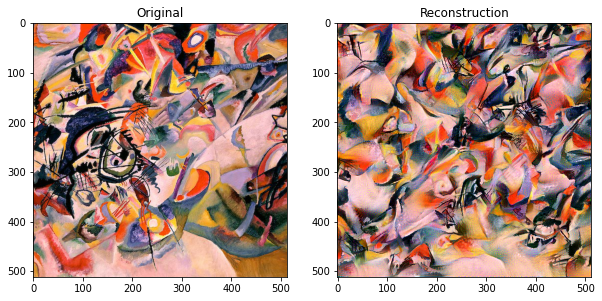

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(texture[0])
ax[1].imshow(reconstruction[0].numpy())

ax[0].set_title('Original')
ax[1].set_title('Reconstruction')

plt.show()